## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import SimpleImputer
import statsmodels.api as sm # for QQ Plot

from sklearn.preprocessing import MinMaxScaler

# Modeling
from scipy.cluster.hierarchy import dendrogram, linkage # Hierarchical Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
import optuna

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("/kaggle/input/ccdata/CC GENERAL.csv").set_index("CUST_ID")
print(df.shape)
df.head()

(8950, 17)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CRED

In [4]:
def custom_describe(data):
    """
    Generate a custom description of a DataFrame including basic statistics, 
    missing values count, unique values count, outliers count, and data types.

    Parameters:
    - data (pd.DataFrame): The pandas DataFrame to be described.

    Returns:
    pd.DataFrame: A custom description DataFrame with the following columns:
    - data_type: Data types for each column.
    - mean: Mean value for each numeric column.
    - std: Standard deviation for each numeric column.
    - missing_values: Count of missing values for each column.
    - unique_values: Count of unique values for each column.
    - outliers: Count of outliers for each numeric column.

    Example:
    custom_description = custom_describe(df)
    """
    
    # Basic statistics
    desc_stats = data.describe()

    # Missing values count
    missing_values = data.isnull().sum()

    # Unique values count
    unique_values = data.nunique()

    # Identify numeric columns
    numeric_cols = data.select_dtypes(include=['number']).columns

    # Calculate IQR and identify outliers for each numeric column
    outliers = {}
    for col in numeric_cols:
        q1 = desc_stats.loc['25%', col]
        q3 = desc_stats.loc['75%', col]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()

    # Get data types for each column
    data_types = data.dtypes
    
    # Combine all information
    custom_description = pd.DataFrame({
        'data_type': data_types,
        'mean': desc_stats.loc['mean'],
        'std': desc_stats.loc['std'],
        'missing_values': missing_values,
        'unique_values': unique_values,
        'outliers': outliers
    })

    return custom_description

In [5]:
print(df.shape)
custom_describe(df)

(8950, 17)


,data_type,mean,std,missing_values,unique_values,outliers
BALANCE,float64,1564.474828,2081.531879,0,8871,695
BALANCE_FREQUENCY,float64,0.877271,0.236904,0,43,1493
PURCHASES,float64,1003.204834,2136.634782,0,6203,808
ONEOFF_PURCHASES,float64,592.437371,1659.887917,0,4014,1013
INSTALLMENTS_PURCHASES,float64,411.067645,904.338115,0,4452,867
CASH_ADVANCE,float64,978.871112,2097.163877,0,4323,1030
PURCHASES_FREQUENCY,float64,0.490351,0.401371,0,47,0
ONEOFF_PURCHASES_FREQUENCY,float64,0.202458,0.298336,0,47,782
PURCHASES_INSTALLMENTS_FREQUENCY,float64,0.364437,0.397448,0,47,0
CASH_ADVANCE_FREQUENCY,float64,0.135144,0.200121,0,54,525


We have here so many outliers and some missing values!

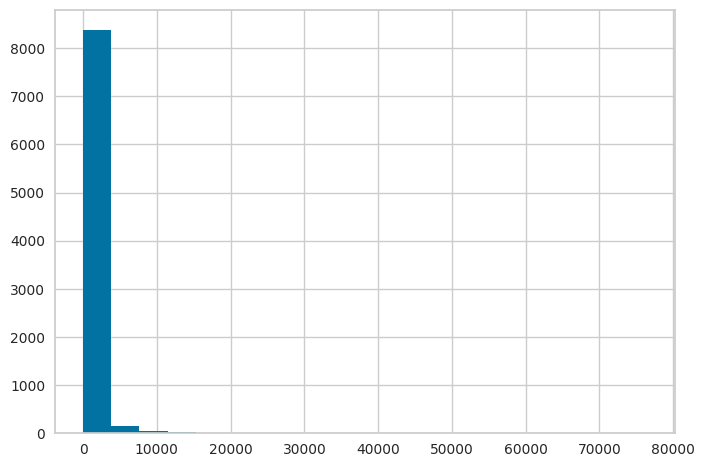

In [6]:
df["MINIMUM_PAYMENTS"].hist(bins=20);

As you can see that the distribution has skewness, so we will impute the nulls by the median vlaue!

In [7]:
imp = SimpleImputer(strategy="median")
df[["CREDIT_LIMIT", "MINIMUM_PAYMENTS"]] = imp.fit_transform(df[["CREDIT_LIMIT", "MINIMUM_PAYMENTS"]])

In [8]:
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

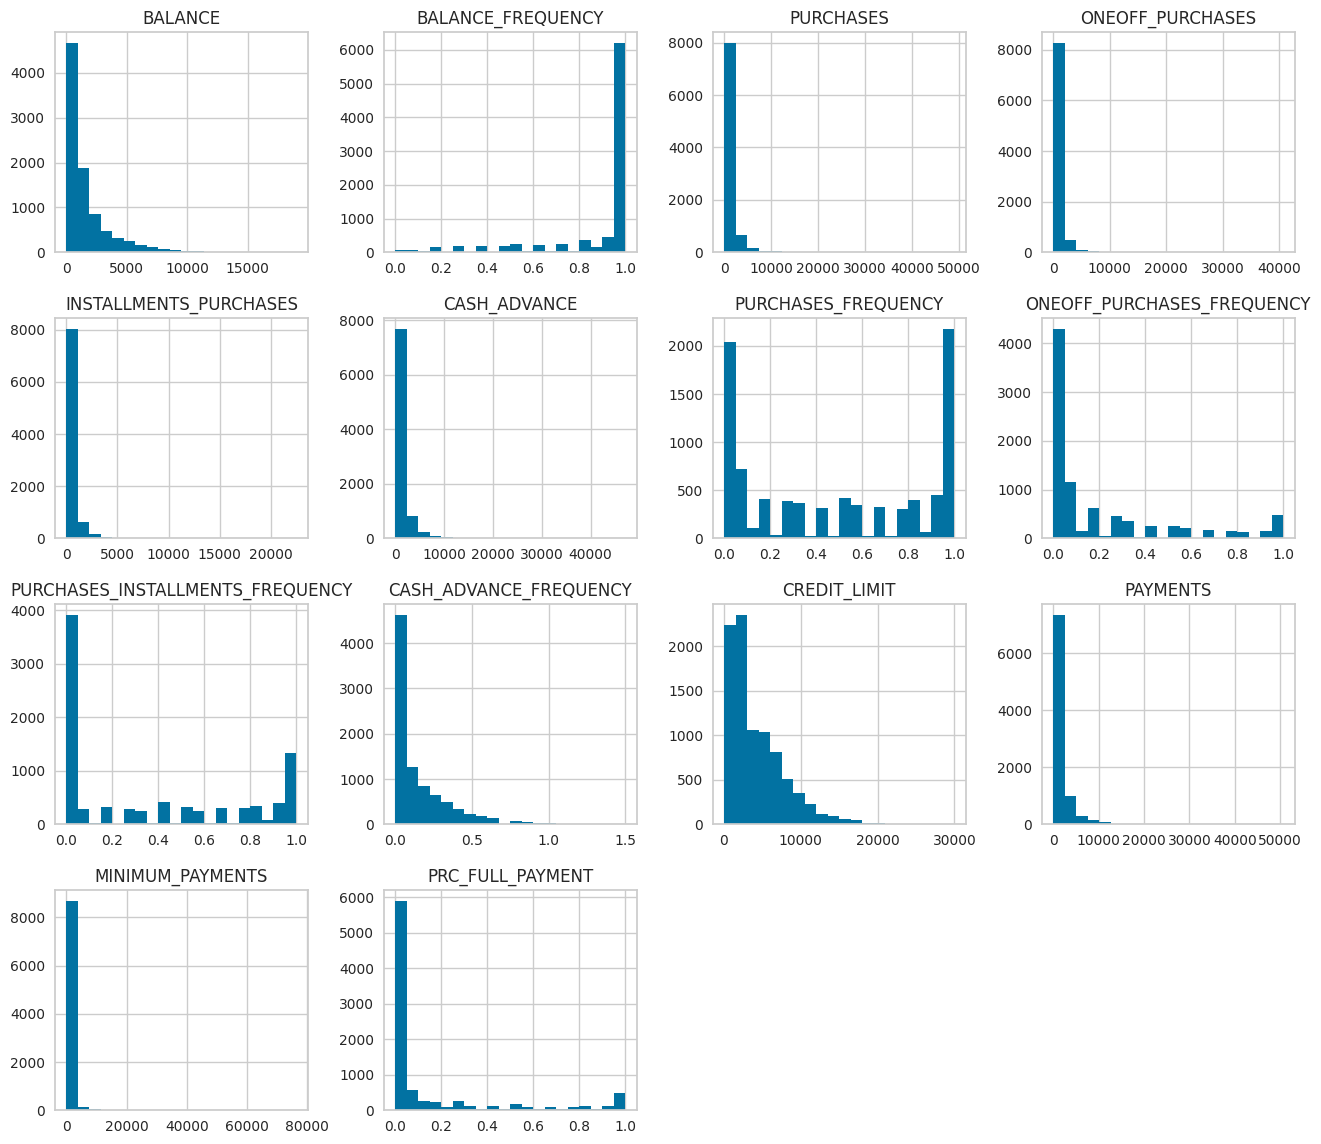

In [9]:
# Check the histogram distribution
df.select_dtypes(float).hist(figsize=(16, 14), bins=20);

In [10]:
def transform_qq(col):
    """
    Visualize the distribution of a numeric column through various transformations 
    and their corresponding Q-Q plots.

    Parameters:
    - col (pd.Series): A pandas Series representing the numeric column to be visualized.

    Returns:
    None

    Plots:
    - Original histogram and Q-Q plot
    - Log transformation histogram and Q-Q plot
    - Square root transformation histogram and Q-Q plot
    - Cube root transformation histogram and Q-Q plot

    Example:
    transform_qq(df['BALANCE'])
    """
    
    # Transformations
    log_transformed = np.log1p(col) 
    sqrt_transformed = np.sqrt(col)  
    cbrt_transformed = np.cbrt(col)

    # Plot histograms and Q-Q plots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Original Histogram
    axes[0, 0].hist(col, bins=20, color='blue', alpha=0.7)
    axes[0, 0].set_title(f'Original {col.name}')

    # Original Q-Q Plot
    sm.qqplot(col, line='s', ax=axes[1, 0])
    axes[1, 0].set_title(f'Original {col.name} Q-Q Plot')

    # Log Transformation Histogram
    axes[0, 1].hist(log_transformed, bins=20, color='green', alpha=0.7)
    axes[0, 1].set_title('Log Transformation')

    # Log Transformation Q-Q Plot
    sm.qqplot(log_transformed, line='s', ax=axes[1, 1])
    axes[1, 1].set_title('Log Transformation Q-Q Plot')

    # Square Root Transformation Histogram
    axes[0, 2].hist(sqrt_transformed, bins=20, color='orange', alpha=0.7)
    axes[0, 2].set_title('Square Root Transformation')

    # Square Root Transformation Q-Q Plot
    sm.qqplot(sqrt_transformed, line='s', ax=axes[1, 2])
    axes[1, 2].set_title('Square Root Transformation Q-Q Plot')

    # Cube Root Transformation Histogram
    axes[0, 3].hist(cbrt_transformed, bins=20, color='purple', alpha=0.7)
    axes[0, 3].set_title('Cube Root Transformation')

    # Cube Root Transformation Q-Q Plot
    sm.qqplot(cbrt_transformed, line='s', ax=axes[1, 3])
    axes[1, 3].set_title('Cube Root Transformation Q-Q Plot')

    plt.tight_layout()
    plt.show()

A **Quantile-Quantile** (Q-Q) plot is a graphical tool used to assess whether a given sample or dataset follows a specific theoretical distribution, such as a normal distribution. The primary use of Q-Q plots is to visually compare the quantiles of the observed data with the quantiles of the expected distribution.

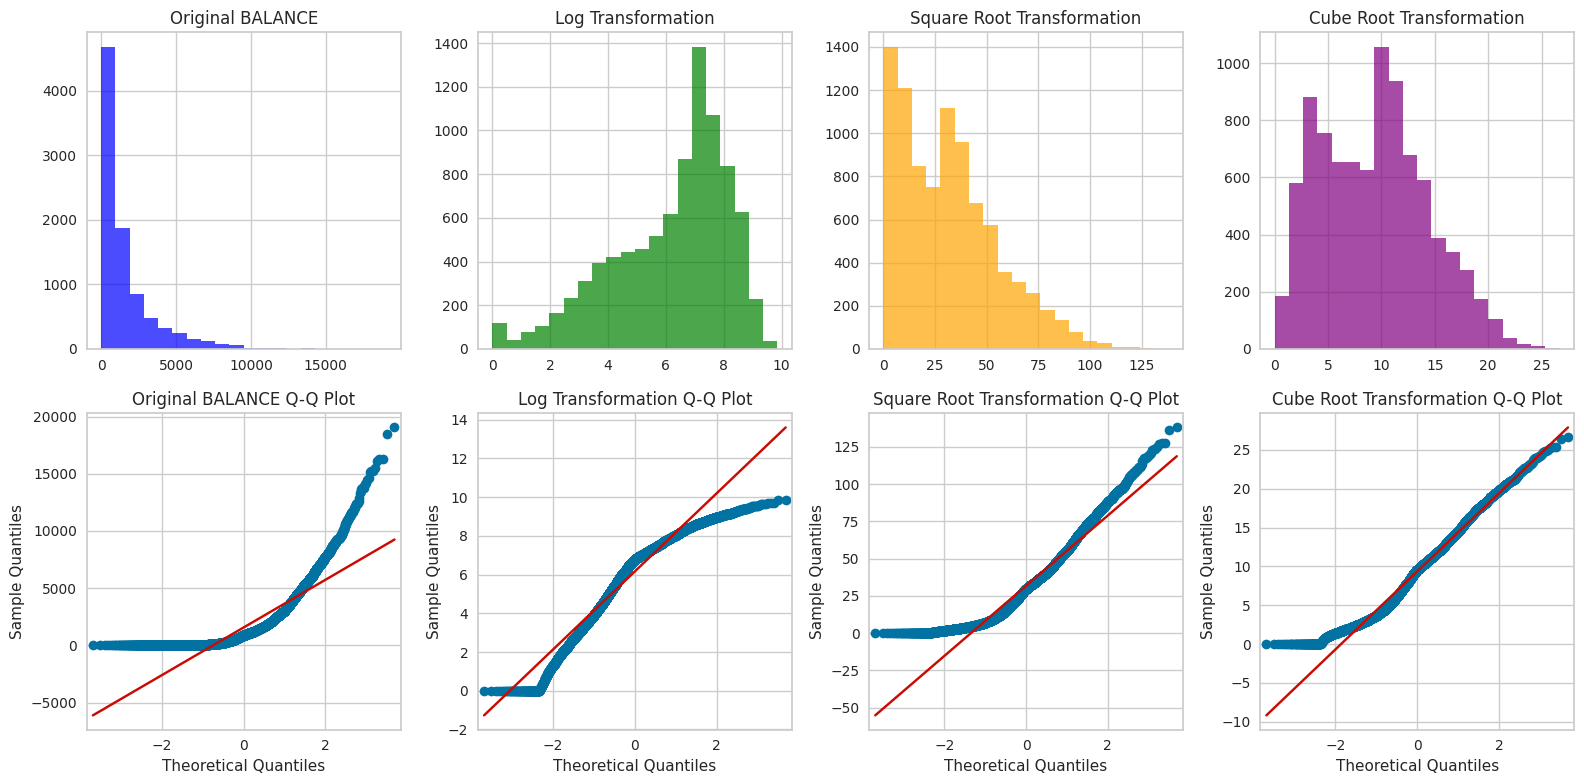

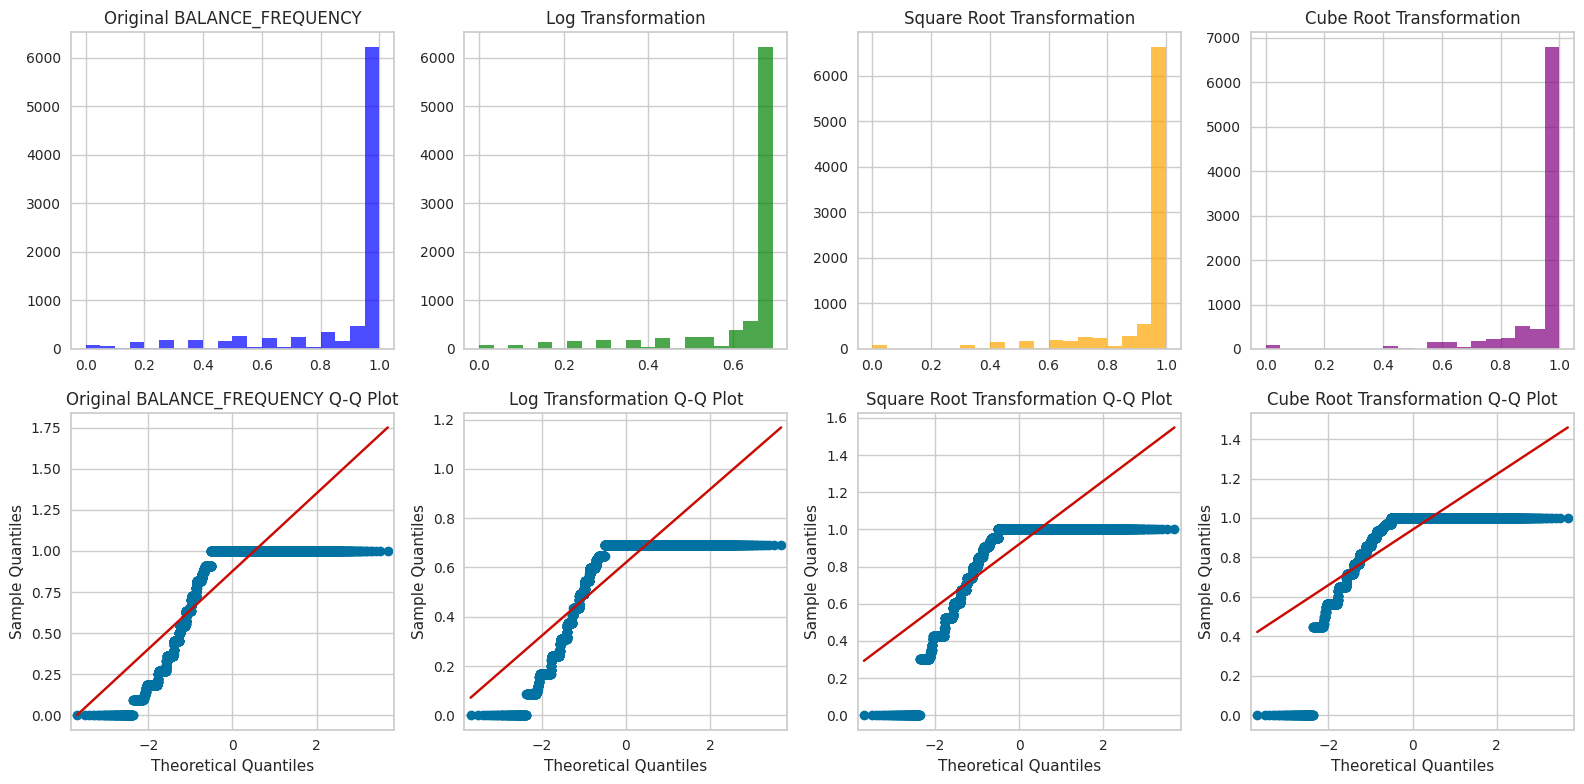

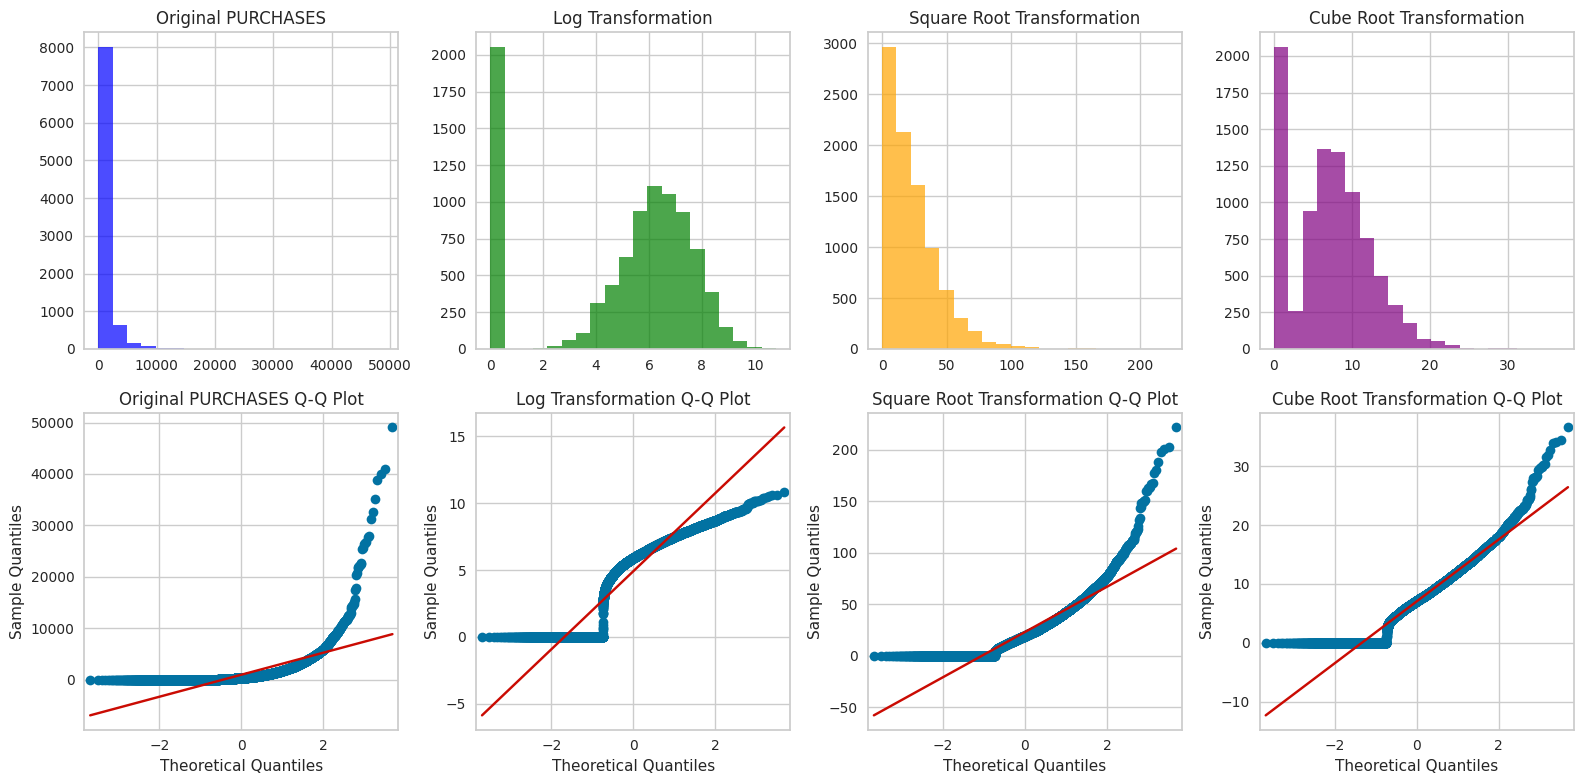

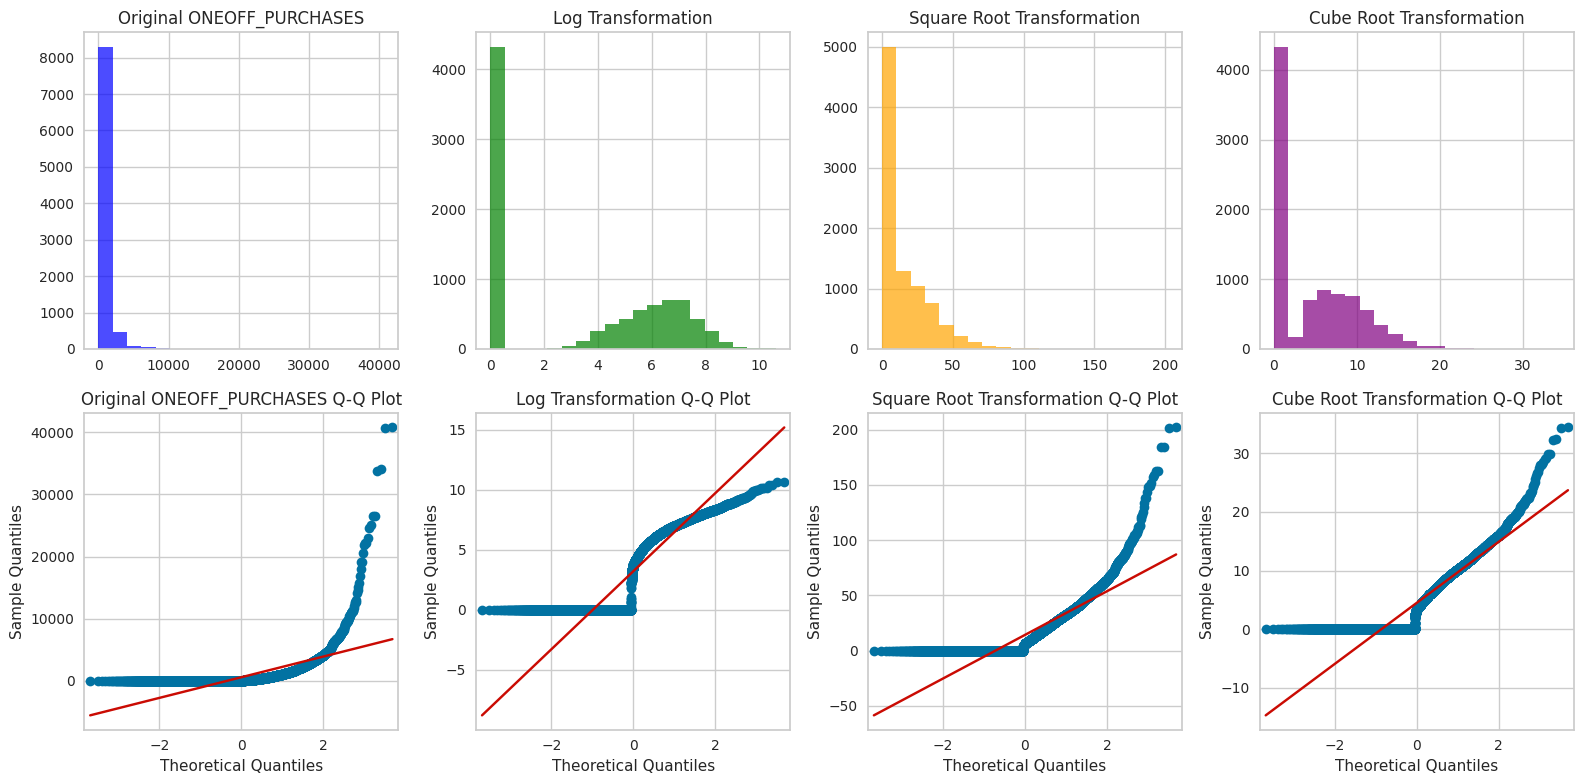

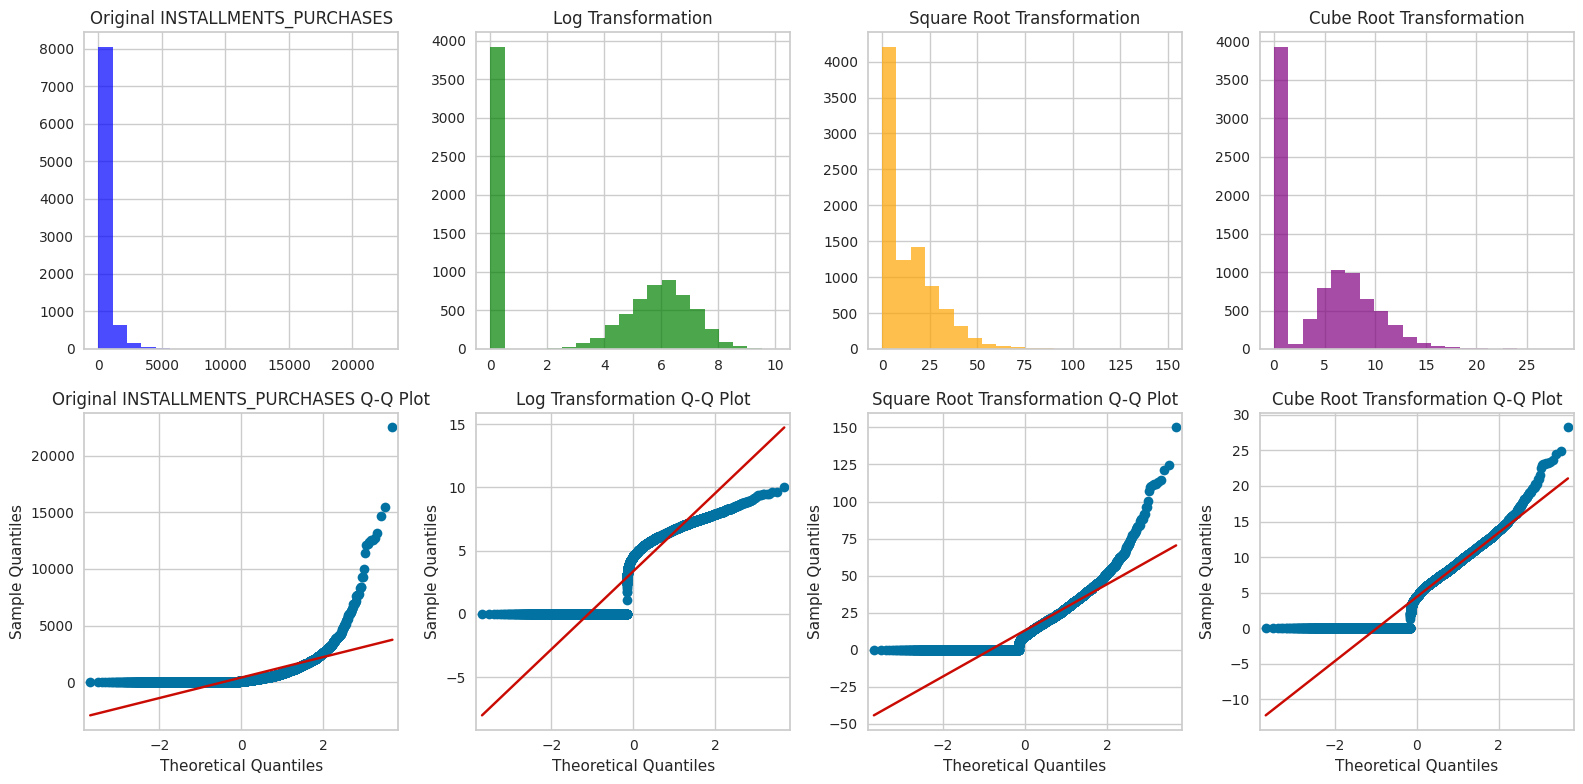

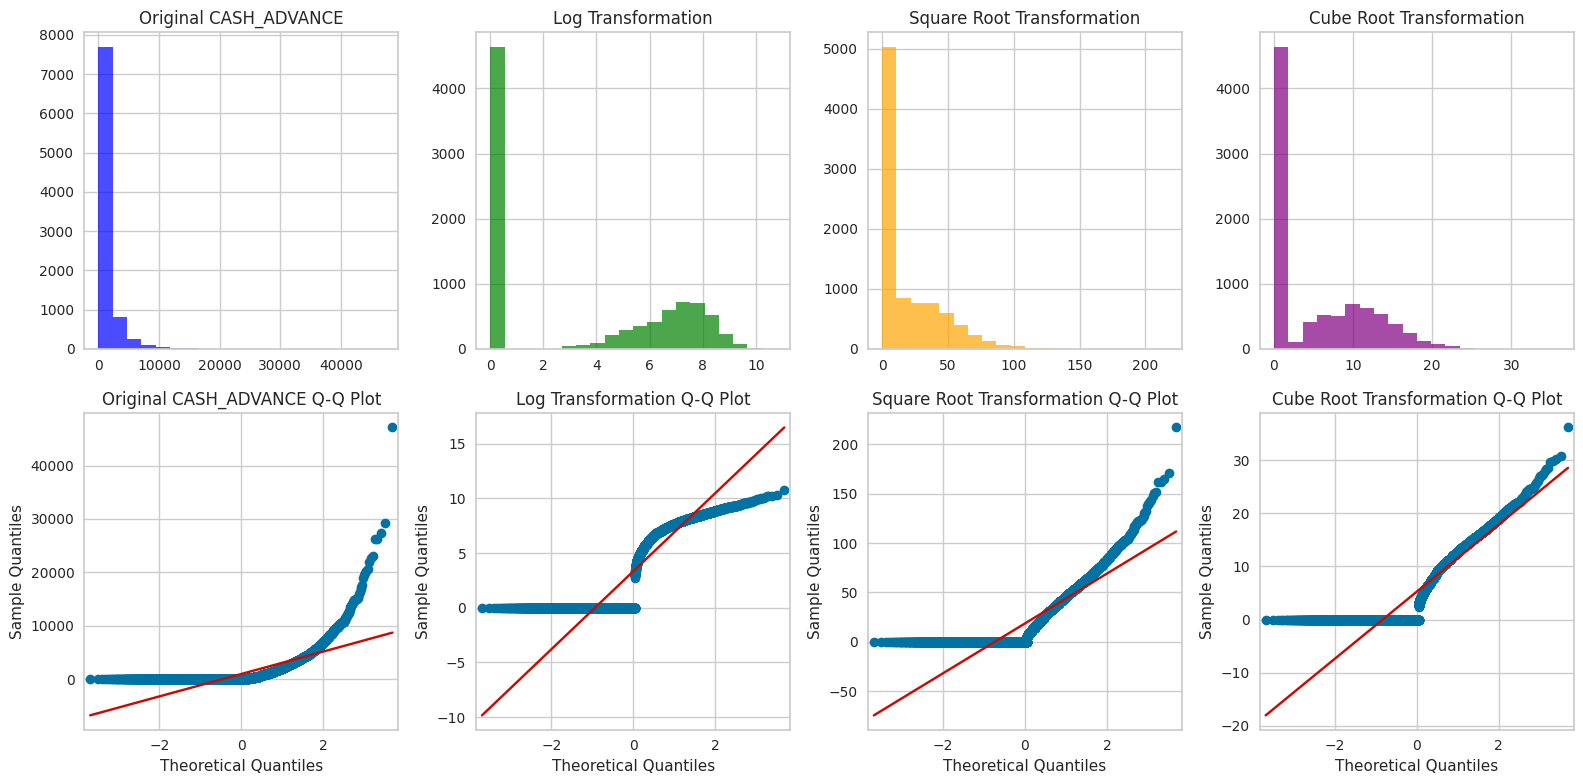

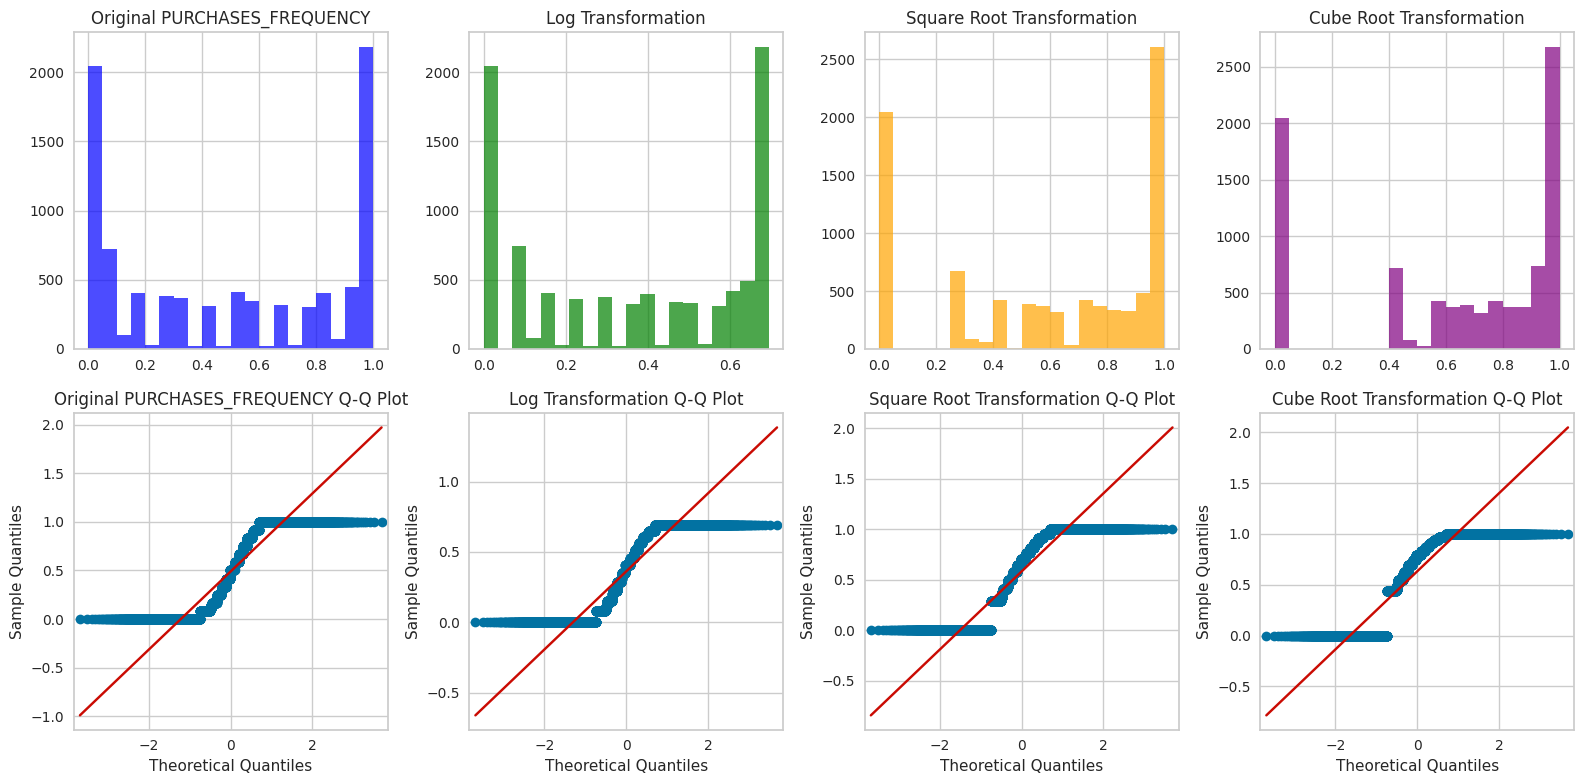

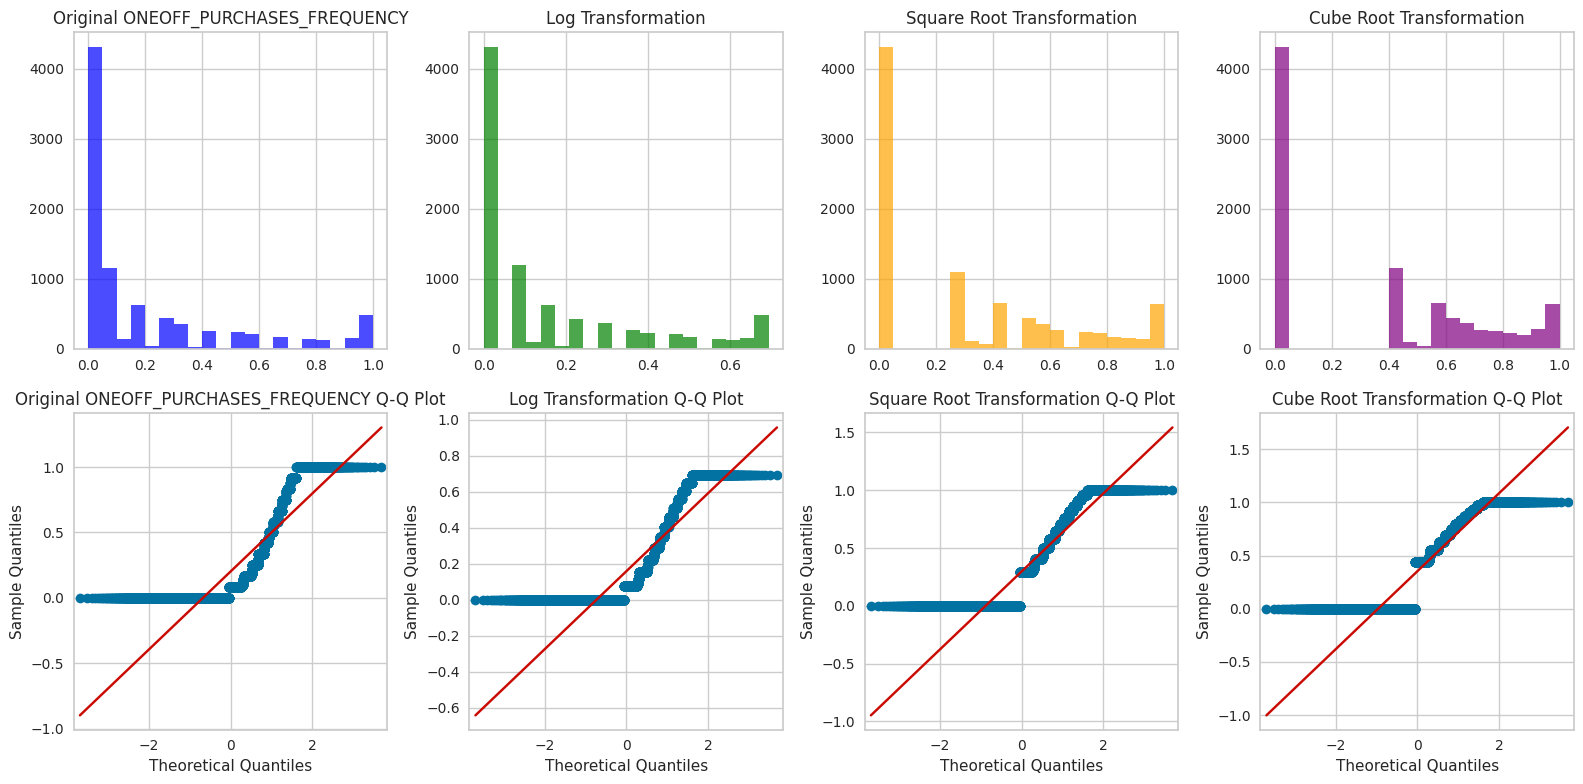

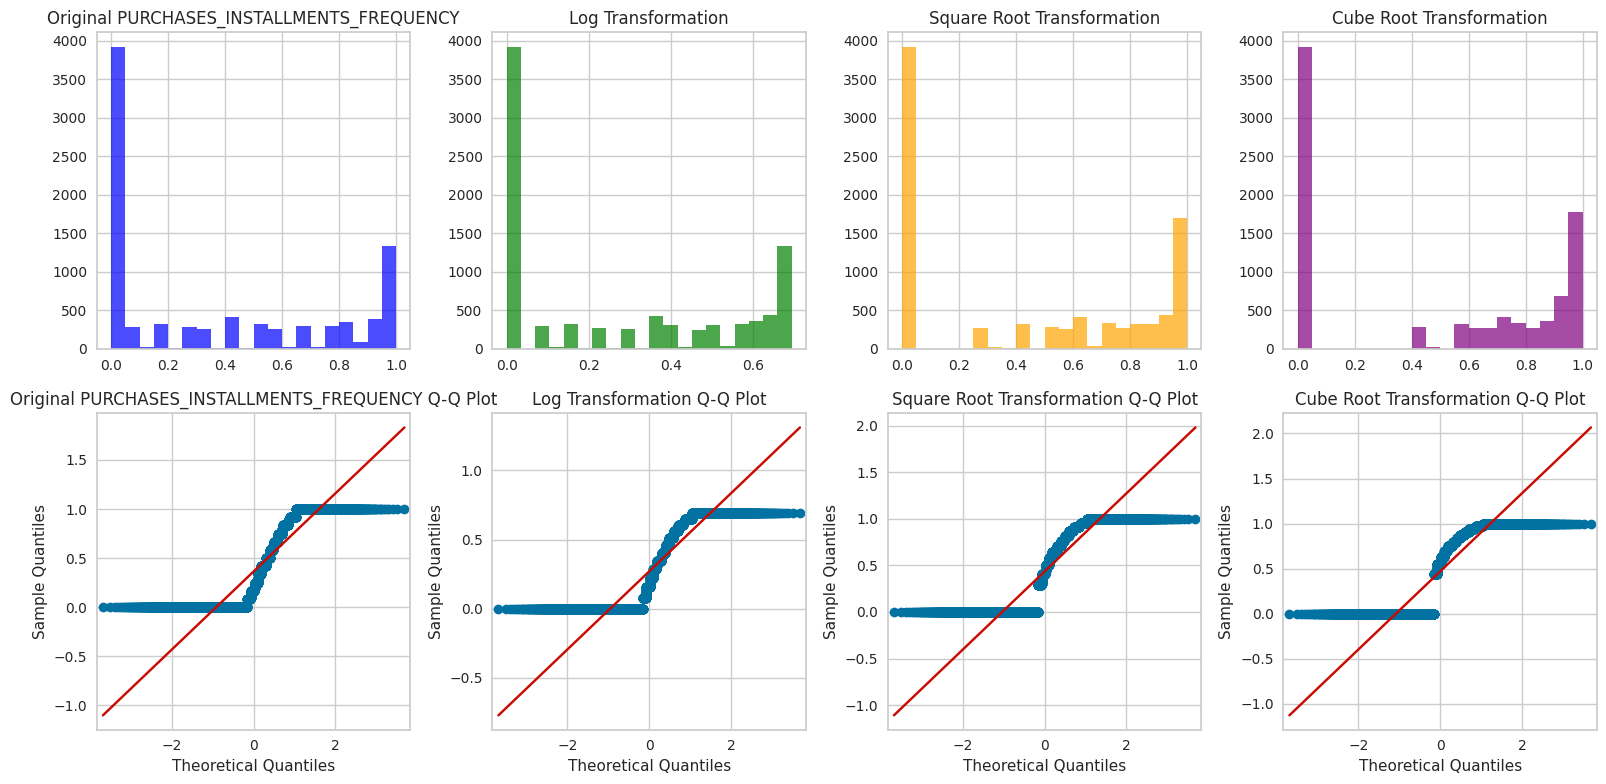

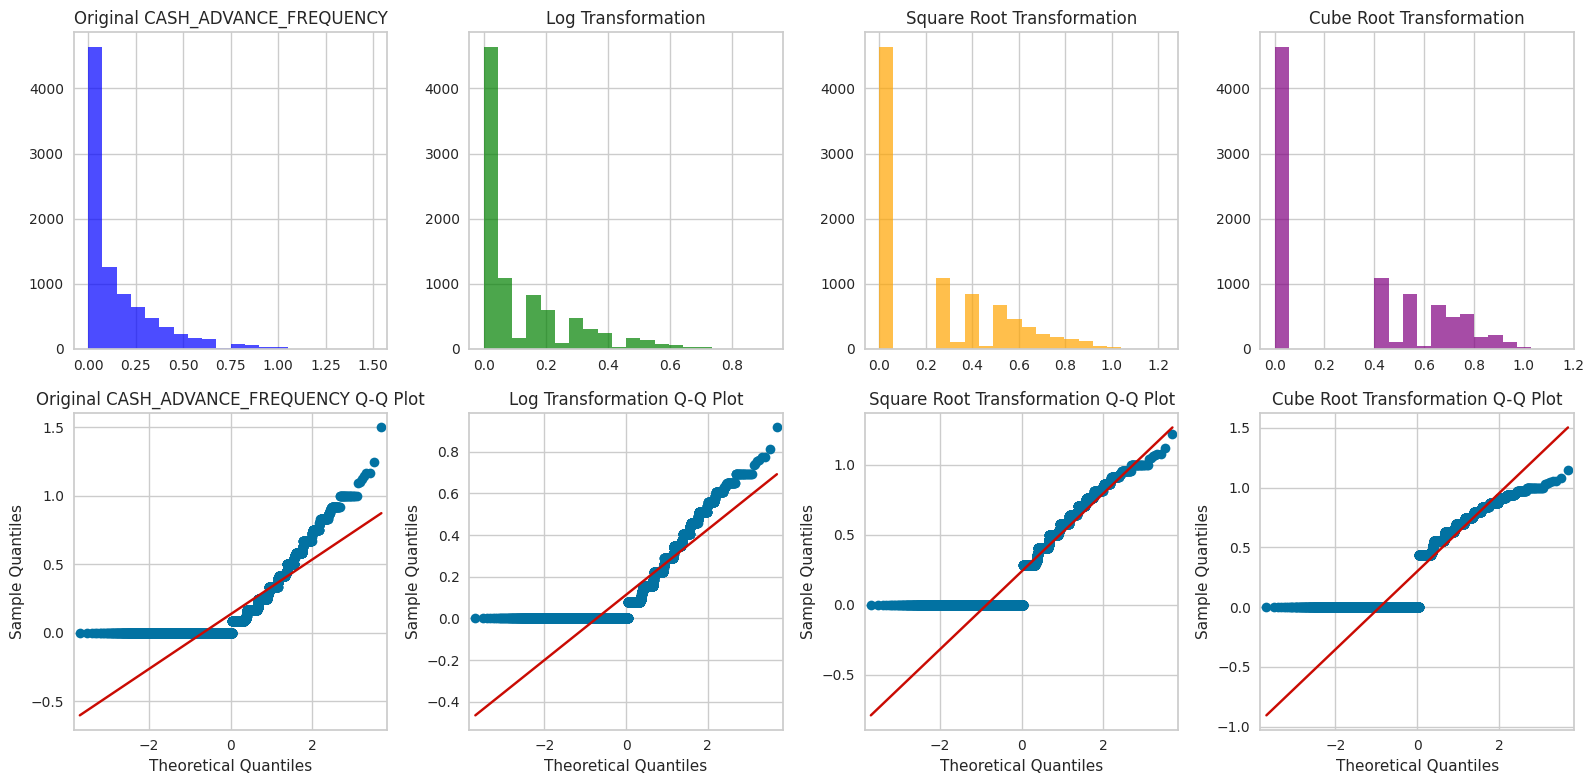

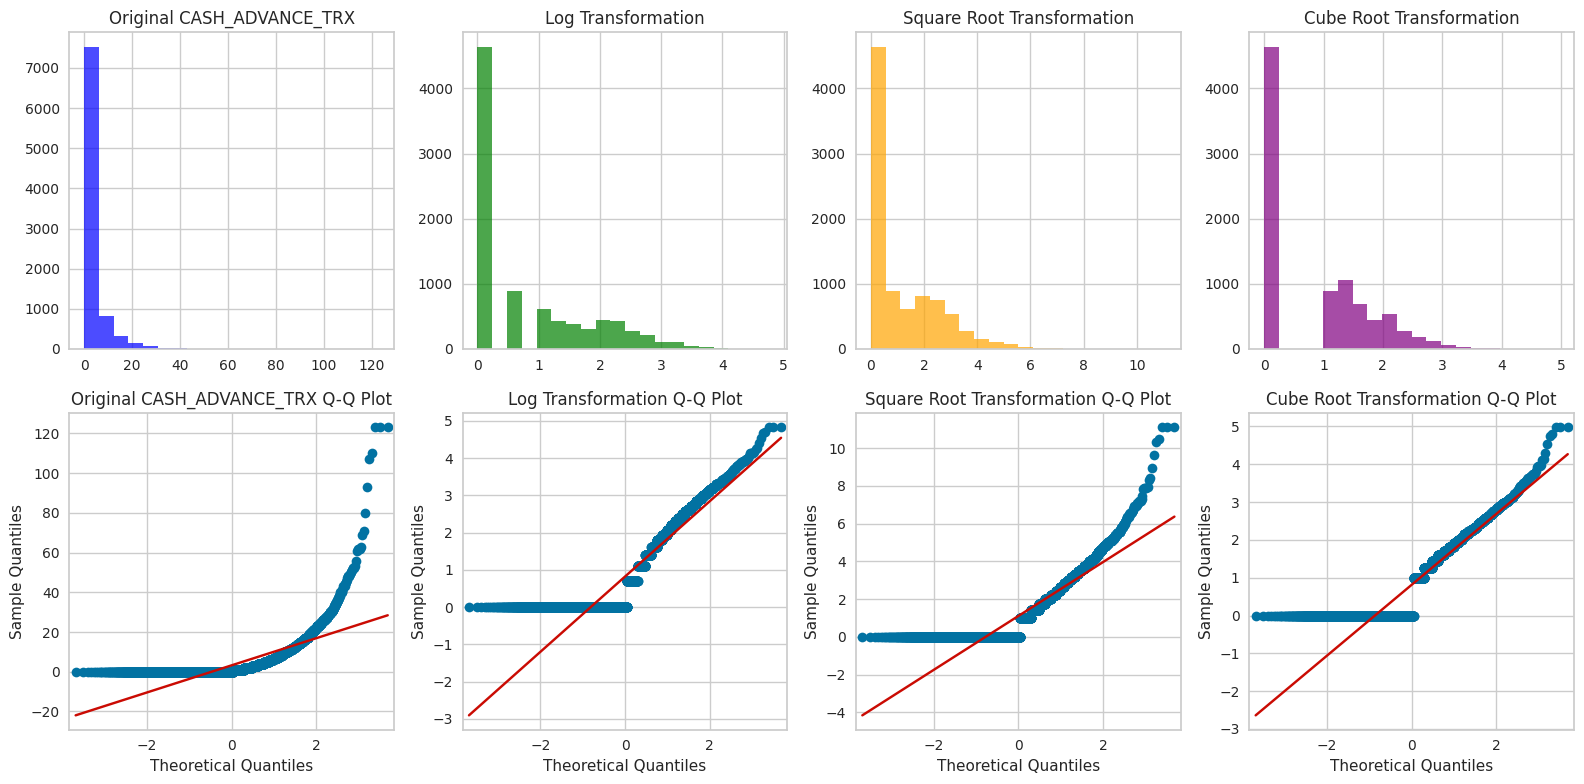

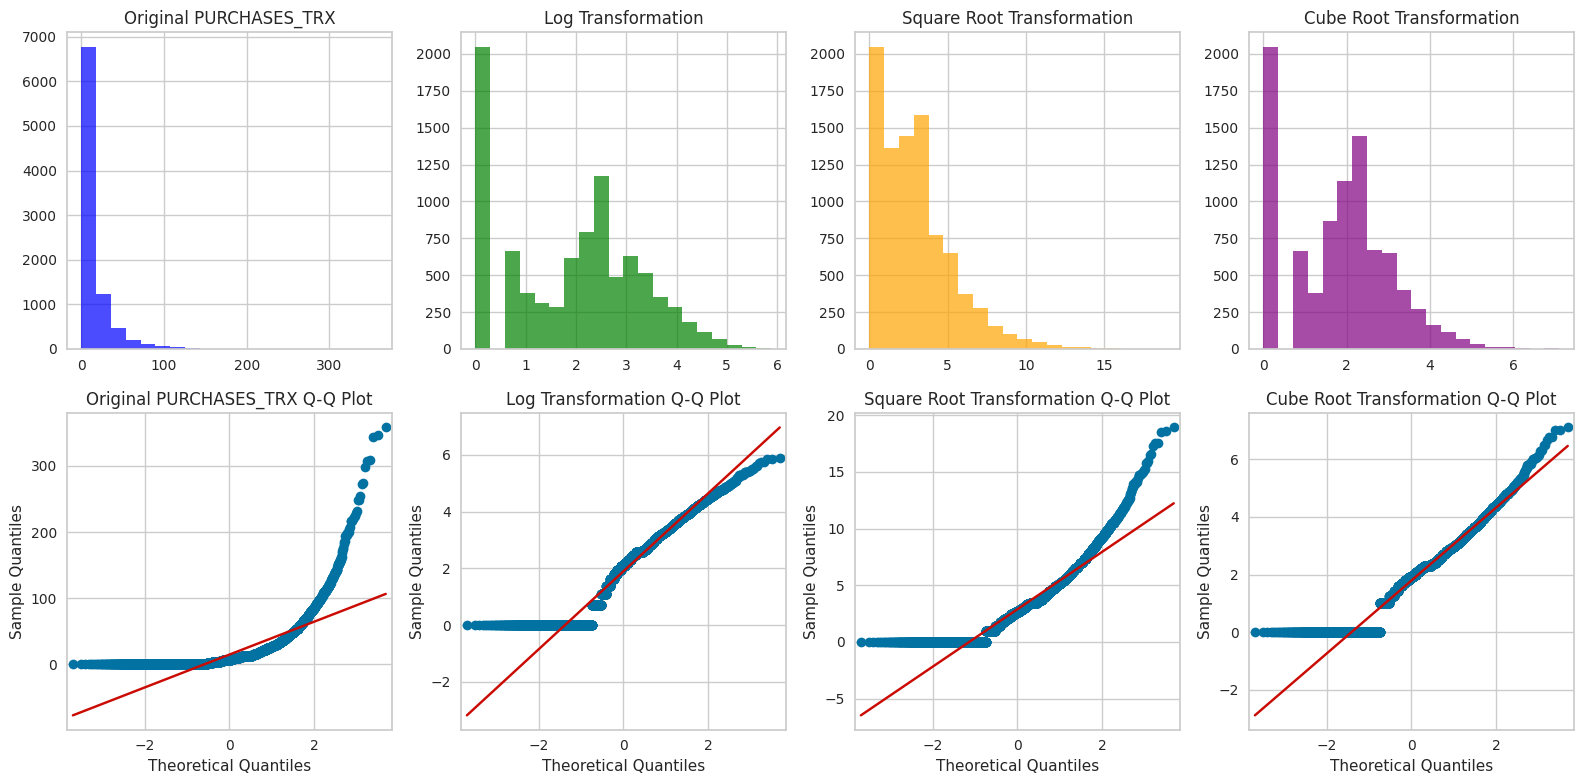

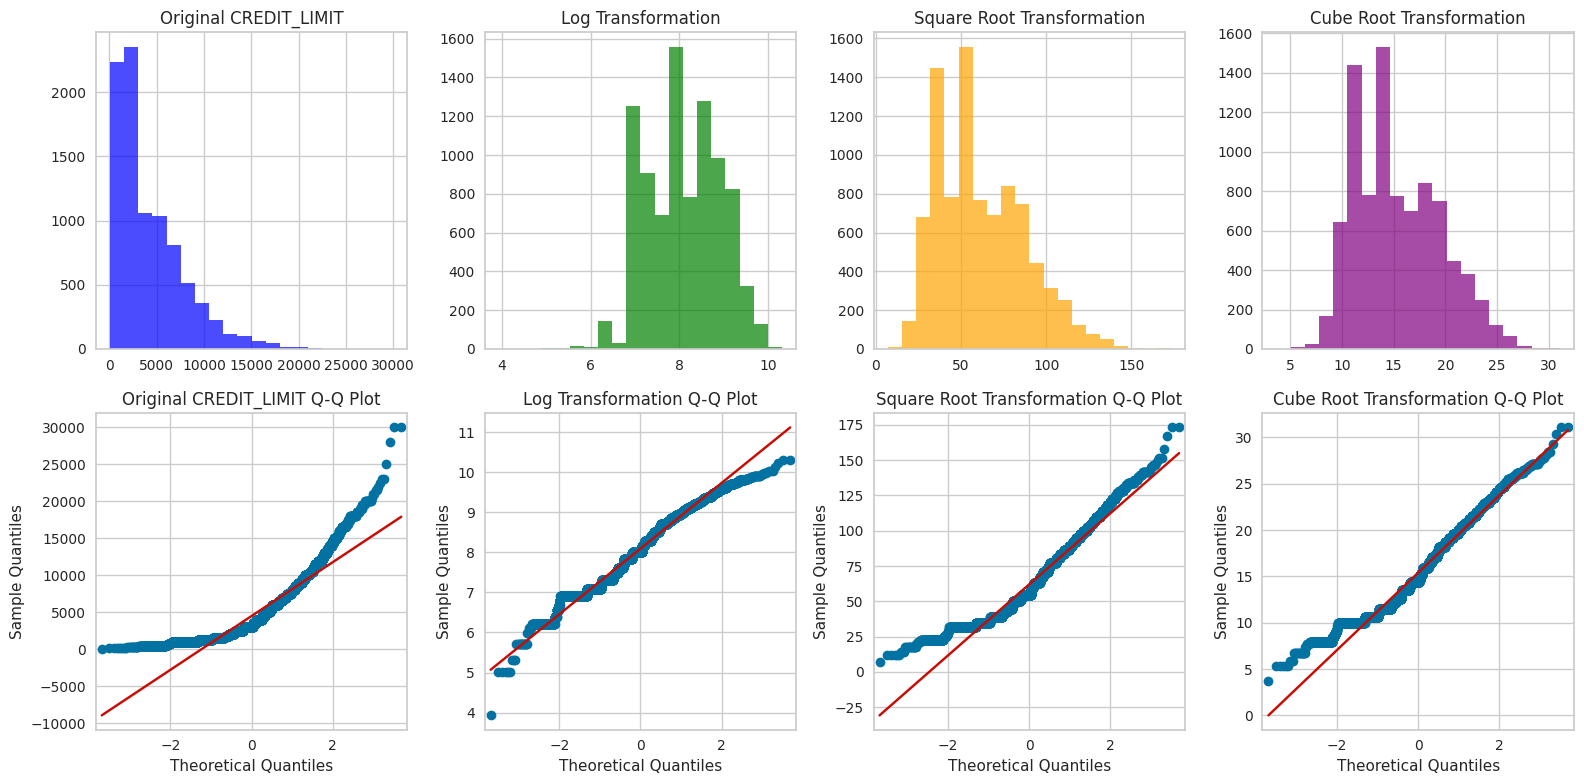

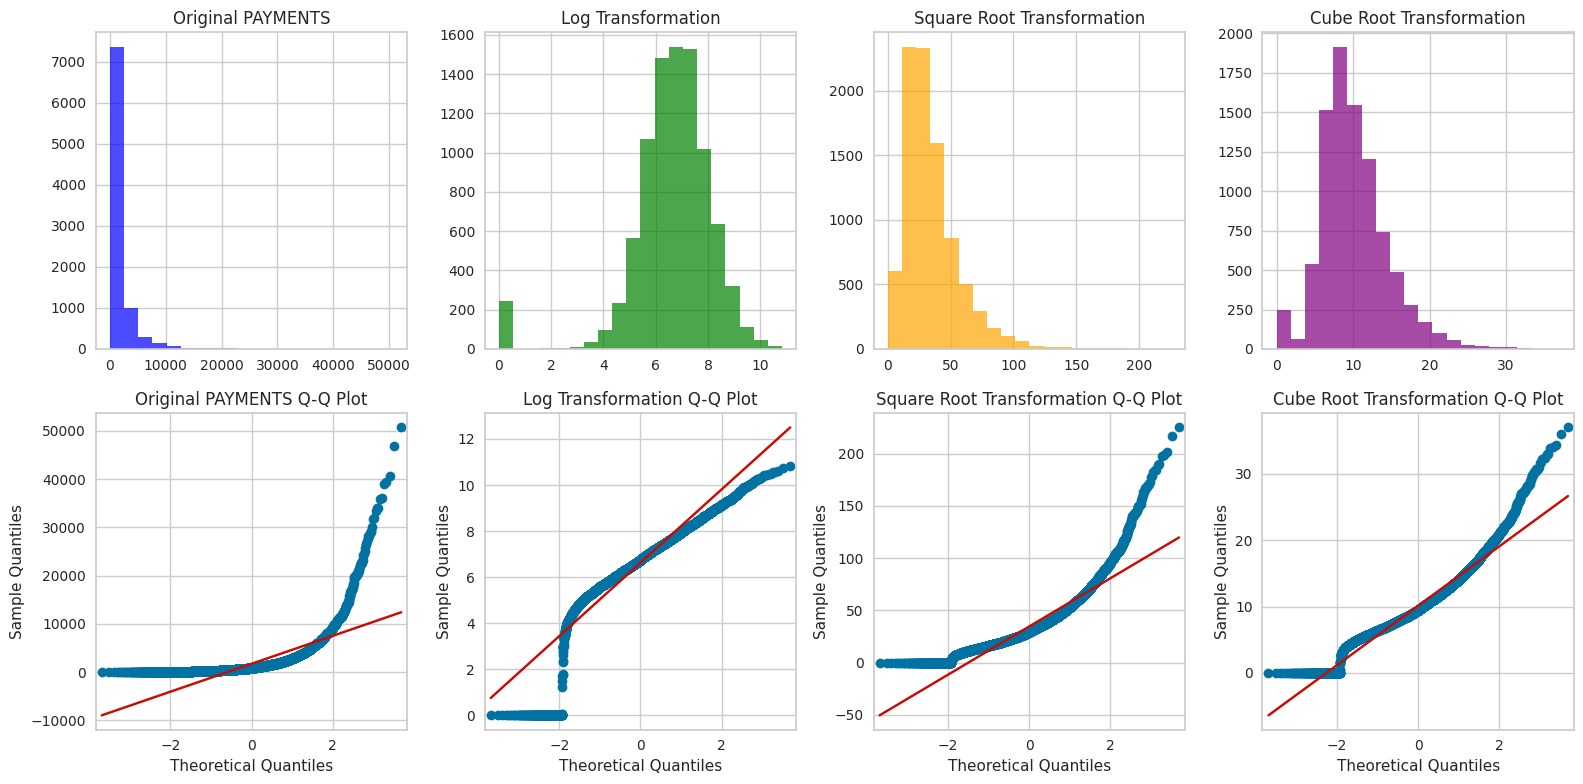

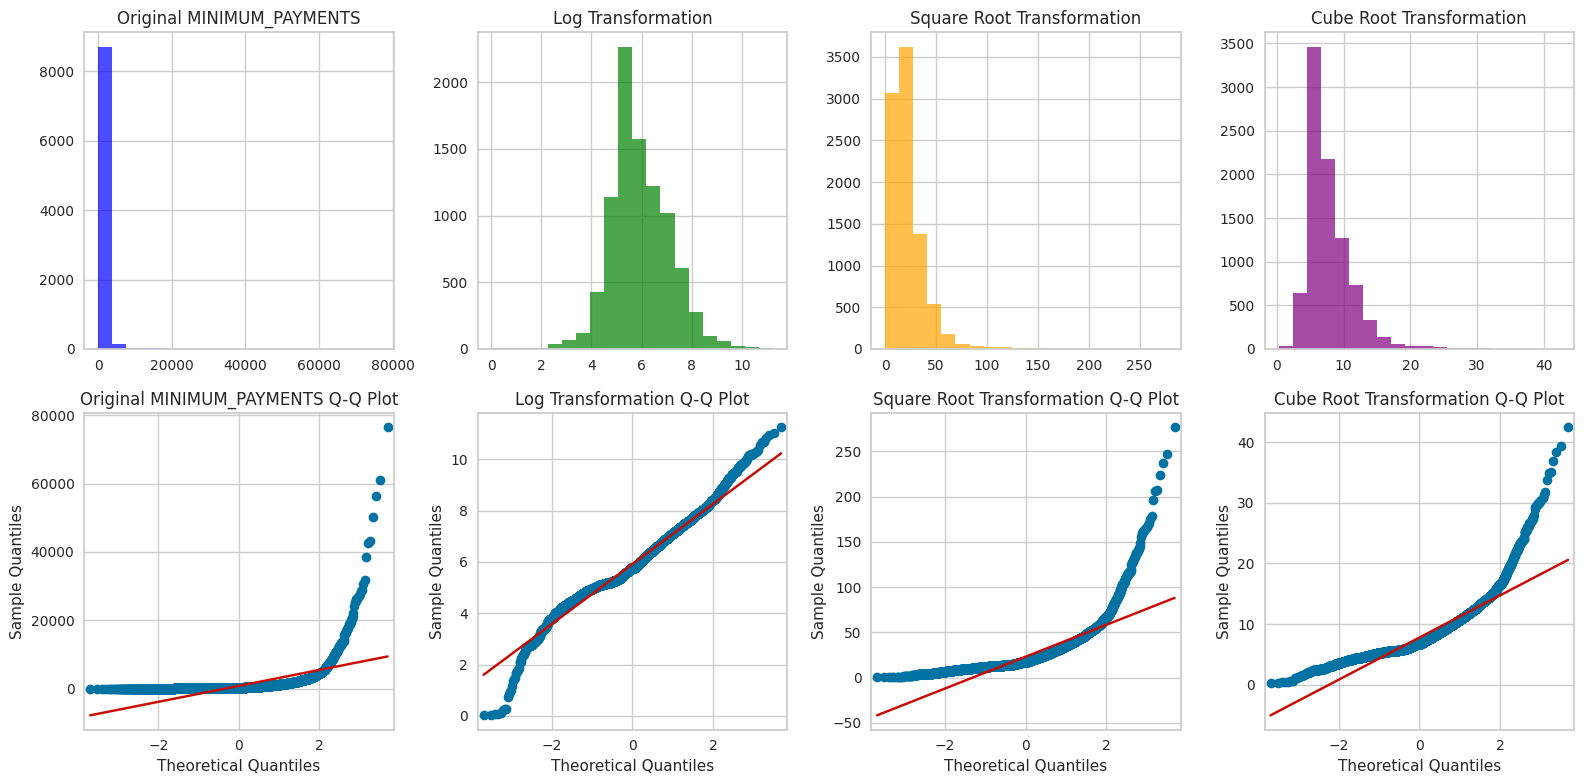

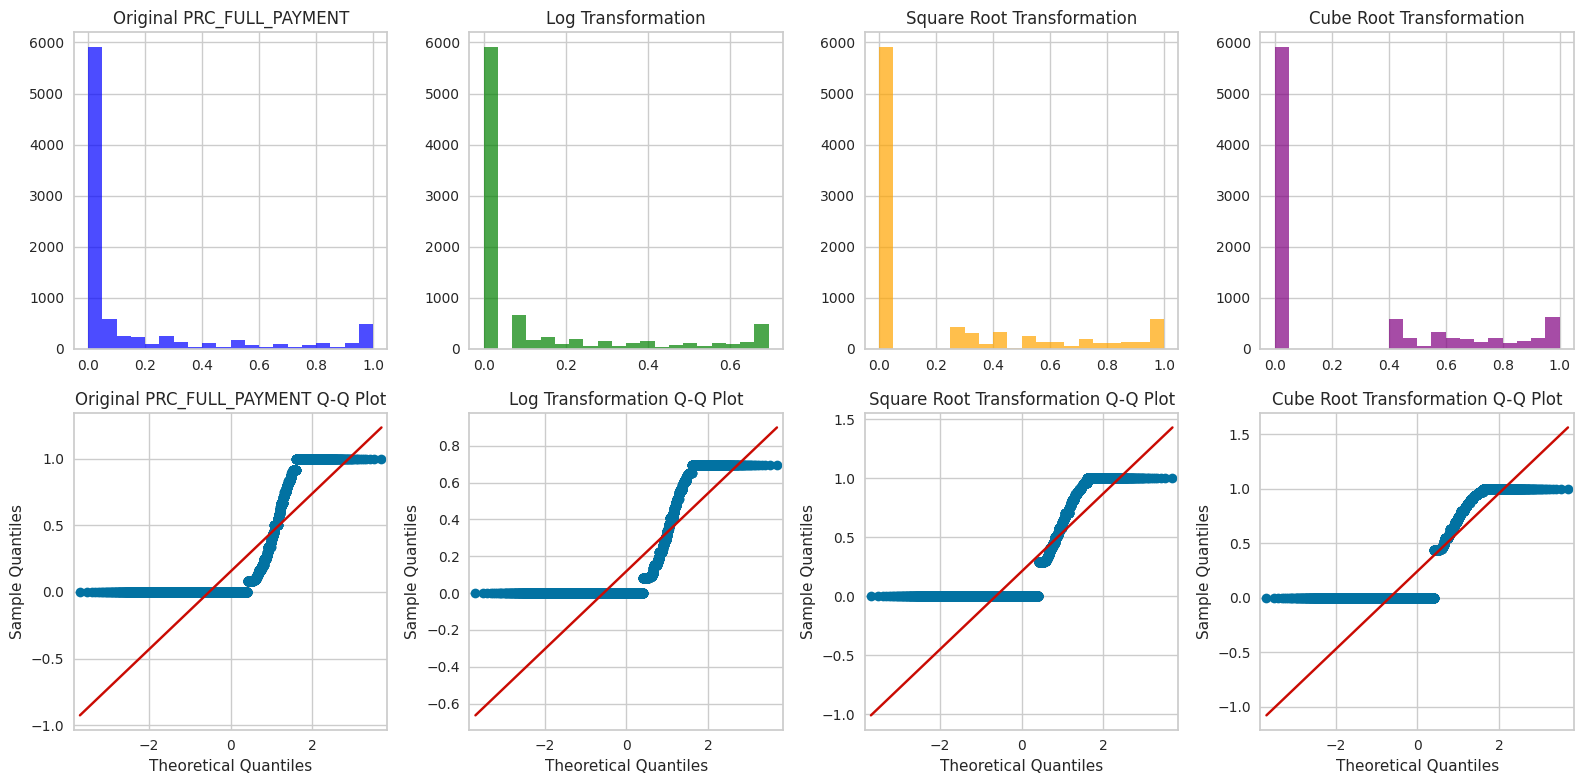

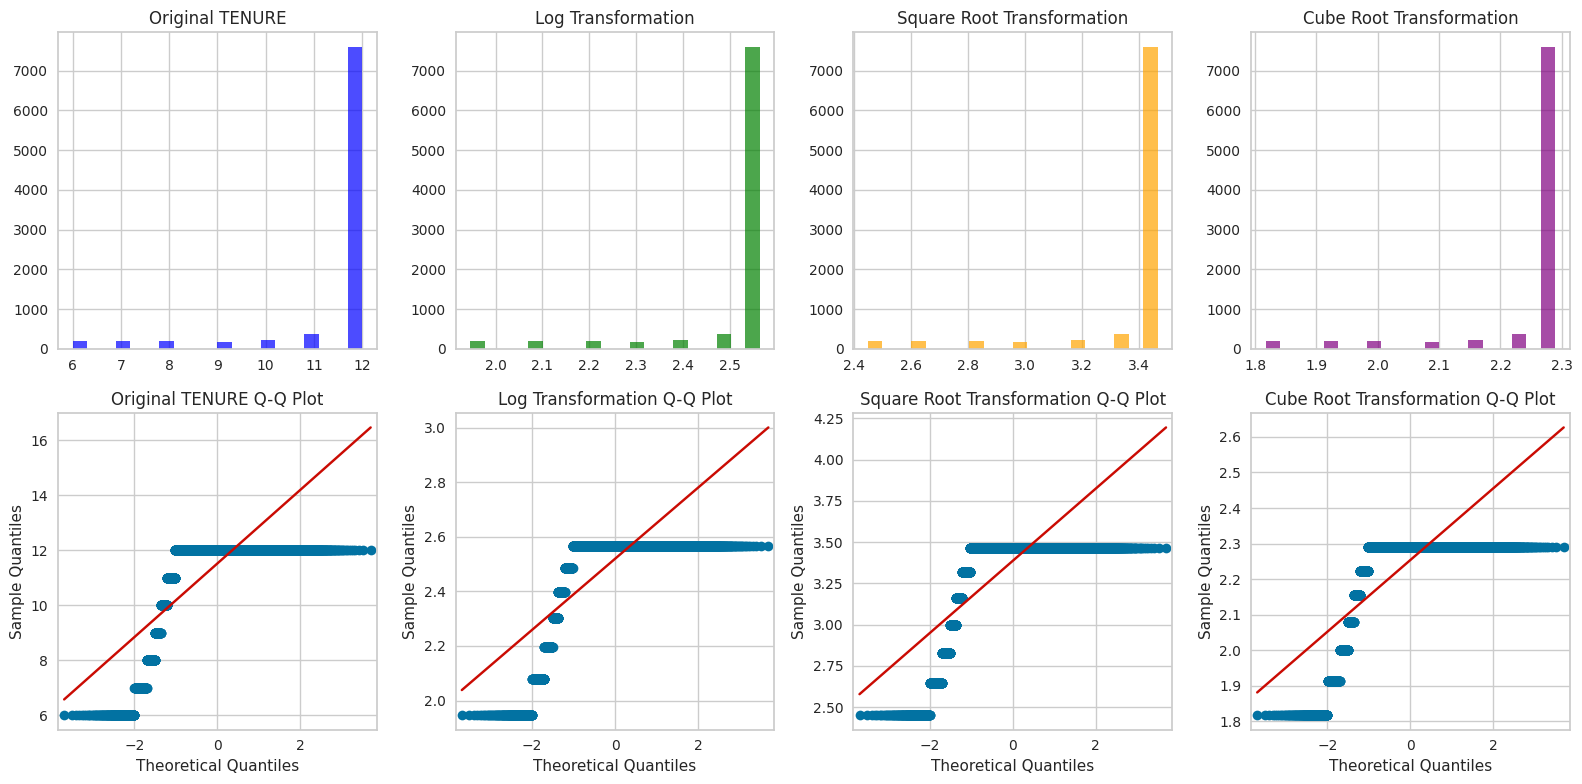

In [11]:
for col in df.columns:
    transform_qq(df[col])
    print("="*200)

How can i know the best plot?
- **Good Fit**: If the points closely follow the line of equality, the data is likely a good fit for a normal distribution.

- **Skewness or Kurtosis**: Curvature away from the line may indicate skewness or kurtosis, suggesting departures from normality.

- **Outliers**: Outliers in the tails can also be identified.

In [12]:
def apply_transformation(df):
    df["BALANCE"] = np.cbrt(df["BALANCE"])
    df["PURCHASES"] = np.cbrt(df["PURCHASES"])
    df["ONEOFF_PURCHASES"] = np.cbrt(df["ONEOFF_PURCHASES"])
    df["INSTALLMENTS_PURCHASES"] = np.cbrt(df["INSTALLMENTS_PURCHASES"])
    df["CASH_ADVANCE"] = np.cbrt(df["CASH_ADVANCE"])
    df["CASH_ADVANCE_FREQUENCY"] = np.sqrt(df["CASH_ADVANCE_FREQUENCY"])
    df["CREDIT_LIMIT"] = np.cbrt(df["CREDIT_LIMIT"])
    df["PAYMENTS"] = np.cbrt(df["PAYMENTS"])
    df["MINIMUM_PAYMENTS"] = np.log1p(df["MINIMUM_PAYMENTS"])
    return df

df = apply_transformation(df)

In [13]:
custom_describe(df)

,data_type,mean,std,missing_values,unique_values,outliers
BALANCE,float64,9.359330,5.019409,0,8871,12
BALANCE_FREQUENCY,float64,0.877271,0.236904,0,43,1493
PURCHASES,float64,7.053038,5.254079,0,6203,90
ONEOFF_PURCHASES,float64,4.504024,5.202814,0,4014,50
INSTALLMENTS_PURCHASES,float64,4.408622,4.513087,0,4452,22
CASH_ADVANCE,float64,5.258267,6.303574,0,4323,14
PURCHASES_FREQUENCY,float64,0.490351,0.401371,0,47,0
ONEOFF_PURCHASES_FREQUENCY,float64,0.202458,0.298336,0,47,782
PURCHASES_INSTALLMENTS_FREQUENCY,float64,0.364437,0.397448,0,47,0
CASH_ADVANCE_FREQUENCY,float64,0.239918,0.278554,0,54,1


We can see that after columns transformation applied there is so many outliers treated!

# Modeling

## 1. Hierarchical Clustering - DendoGram

DendoGram can be a part of EDA process

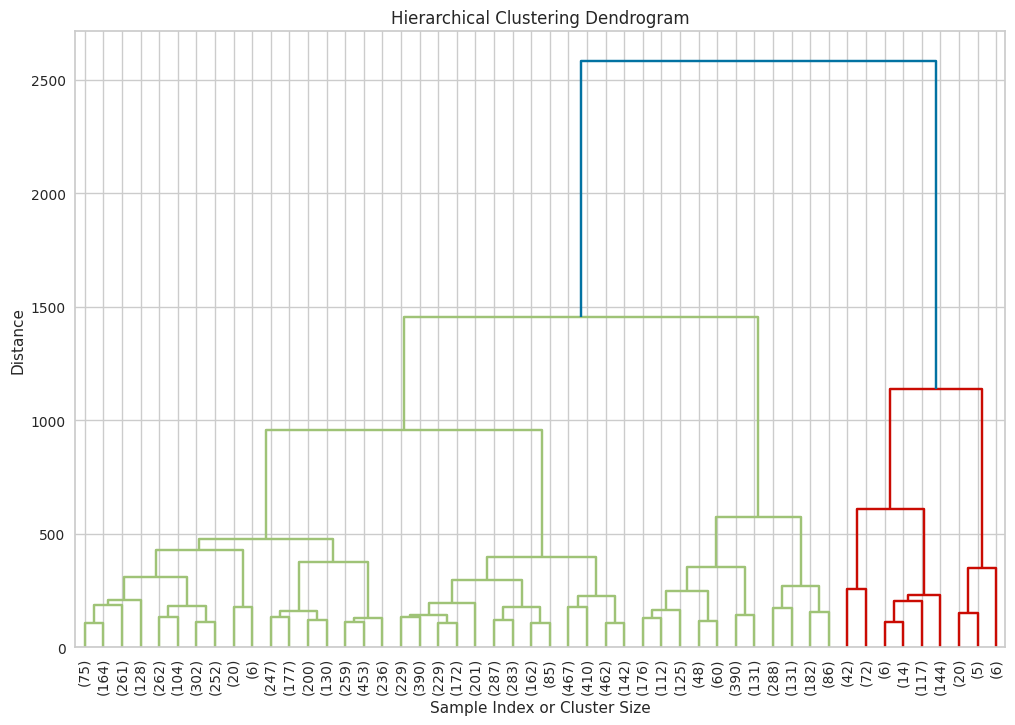

In [14]:
linked = linkage(df, method='ward', metric='euclidean')

plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp',
           p=50,  # Display only the last p merged clusters
           leaf_font_size=10,
           labels=df.index)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

Insights from DendoGram:
- **Cluster Similarity**: The height at which two branches or clusters merge in the dendrogram indicates the similarity between them. Lower fusion heights suggest closer similarity.

- **Cluster Separation**: Vertical lines in the dendrogram represent the division of clusters. The longer the vertical line, the more dissimilar the subclusters are.



## 2. Partitional Clustering - K-Means

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

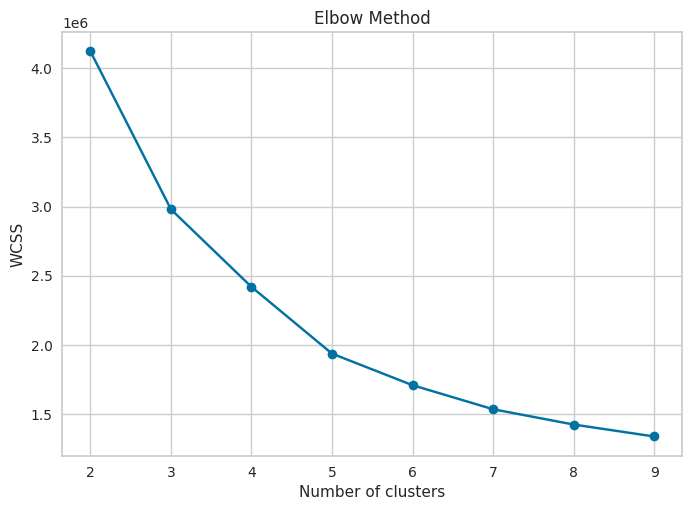

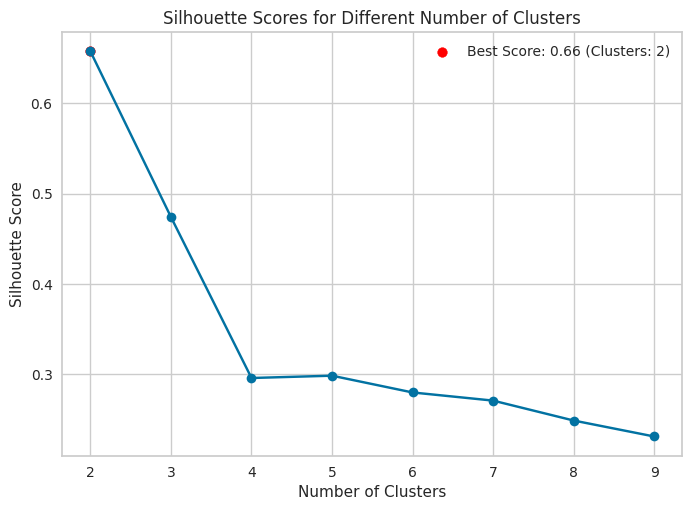

The best silhouette score is 0.66 for 2 clusters.


In [15]:
n_clusters_range = range(2, 10)
silhouette_scores = []
wcss = []                                

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, labels)
    silhouette_scores.append(silhouette_avg)
    wcss.append(kmeans.inertia_)                                   

# Find the best silhouette score and the corresponding number of clusters
best_score = max(silhouette_scores)
best_clusters = n_clusters_range[silhouette_scores.index(best_score)]

plt.plot(n_clusters_range, wcss, '-o')                                
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Plot the silhouette scores
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.scatter(best_clusters, best_score, color='red', label=f'Best Score: {best_score:.2f} (Clusters: {best_clusters})')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.legend()
plt.show()

print(f"The best silhouette score is {best_score:.2f} for {best_clusters} clusters.")

For K-means, the best K is 2 clusters. It's gives us a Silhouette score with 0.66!

In [16]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

### Principal Components Analysis (PCA)

We will use PCA for visualize the clusters in 2d and 3d.

In [17]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = model.predict(df)

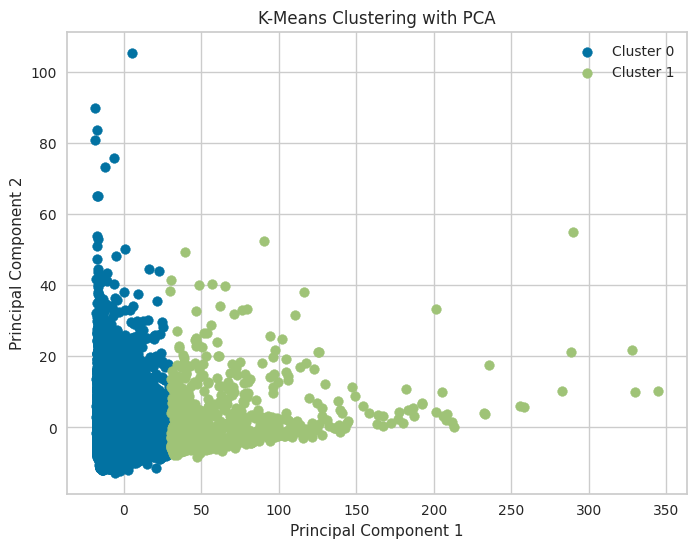

In [18]:
plt.figure(figsize=(8, 6))

for cluster in df_pca['Cluster'].unique():
    cluster_data = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [19]:
clusters_3d = px.scatter_3d(
    x = df_pca["PC1"],
    y = df_pca["PC2"],
    z = df_pca["PC3"],
    color = model.labels_,
    title = "Clusters 3D"
)
clusters_3d.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



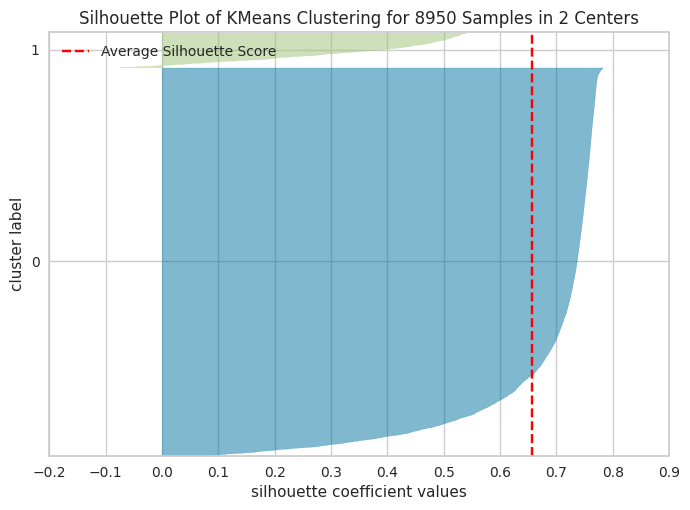

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



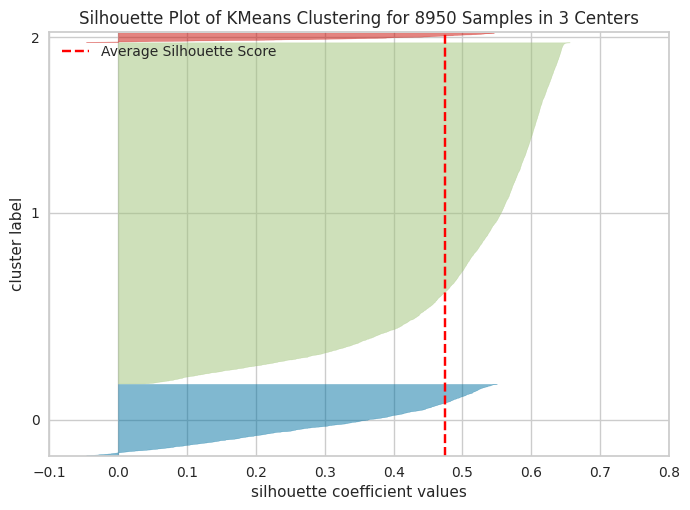

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



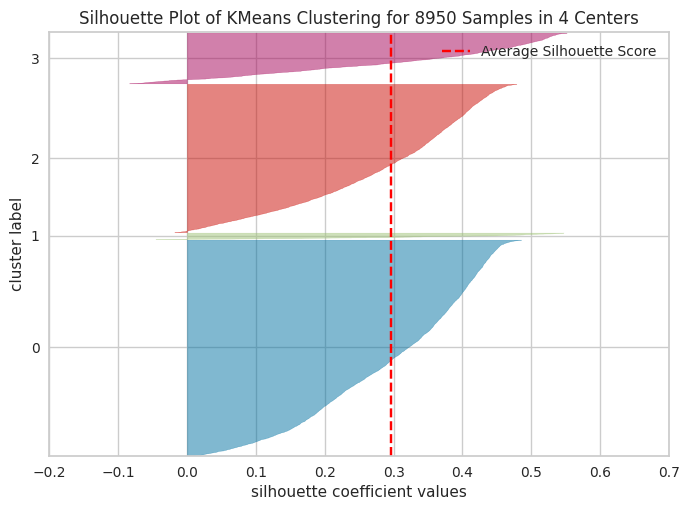

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



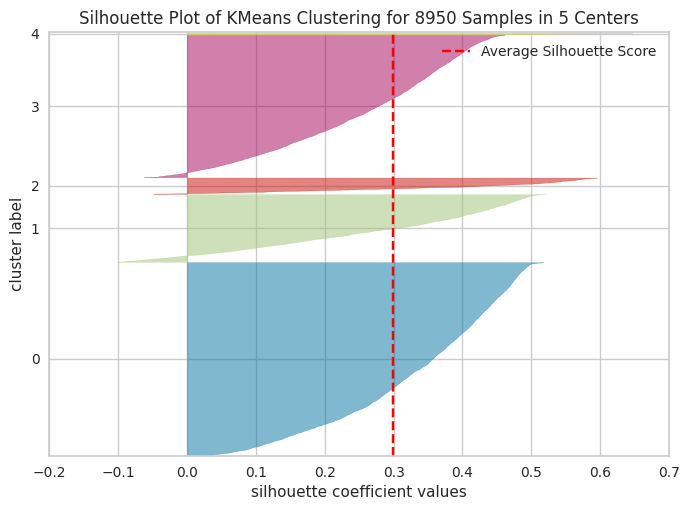

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



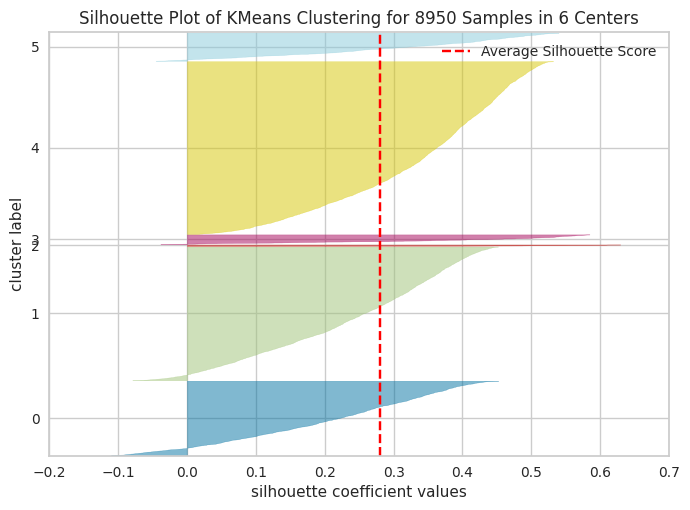

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



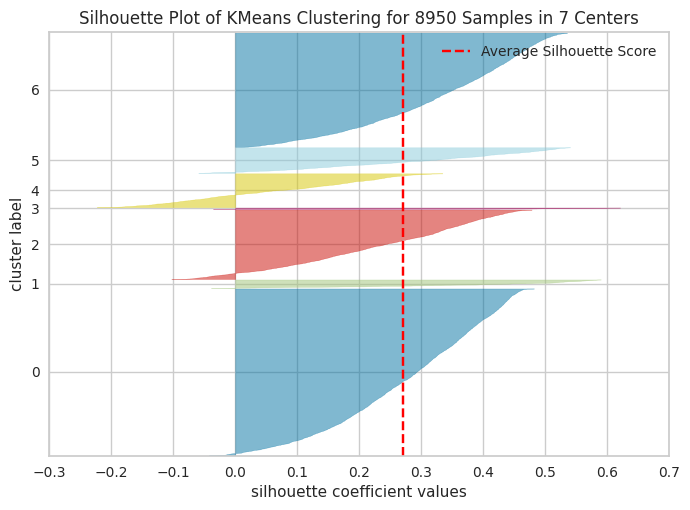

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



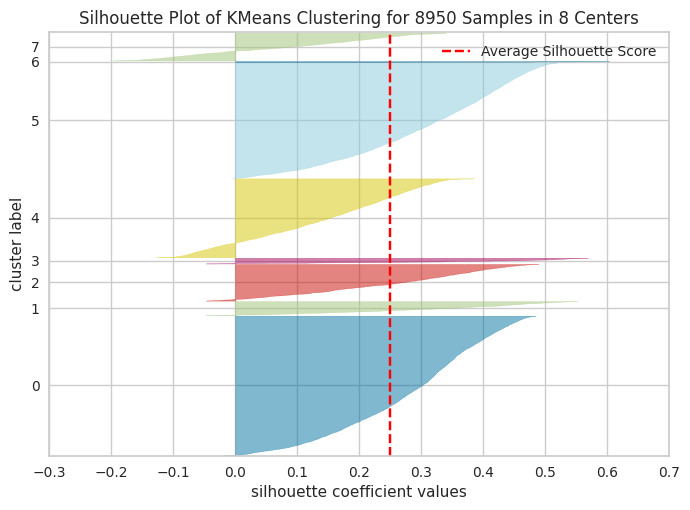

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



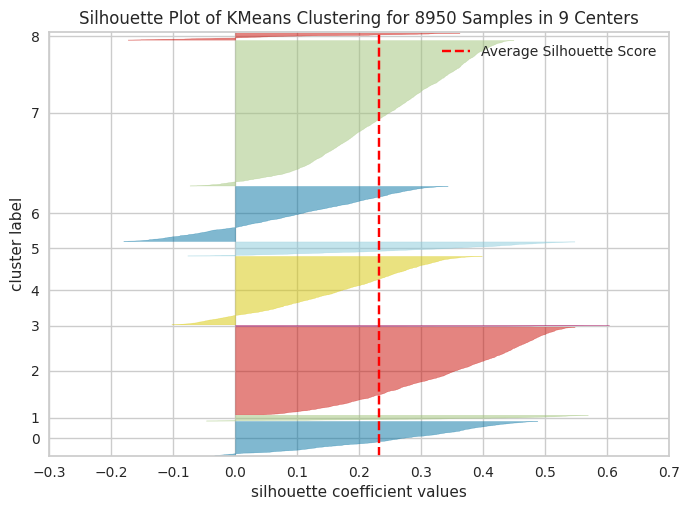

In [20]:
# Instantiate the clustering model and visualizer
for i in range (2,10):
    model = KMeans(i, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(df)        # Fit the data to the visualizer
    visualizer.poof()        # Finalize an

## 3. Density-Based Clustering - DBSCAN

In [21]:
# Perform scaling to the dataset for apply DBSCAN
scaled_df = MinMaxScaler().fit_transform(df)

### Optuna for Hyperparameter Tunning

In [22]:
def objective(trial):
    eps = trial.suggest_float('eps', 0.1, 1.0)
    min_samples = trial.suggest_int('min_samples', 10, 150)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_df)

    try:
        silhouette_avg = silhouette_score(scaled_df, labels)
    except ValueError:  # Silhouette score may raise a ValueError if there's only one cluster
        silhouette_avg = -1

    return silhouette_avg

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-04 20:23:27,253] A new study created in memory with name: no-name-ce5ef1ce-2fbb-478d-8d02-110c6dcefd87
[I 2024-02-04 20:23:28,463] Trial 0 finished with value: 0.2934656012023367 and parameters: {'eps': 0.6718448874318484, 'min_samples': 116}. Best is trial 0 with value: 0.2934656012023367.
[I 2024-02-04 20:23:29,414] Trial 1 finished with value: 0.20184613320865905 and parameters: {'eps': 0.48506310787761364, 'min_samples': 120}. Best is trial 0 with value: 0.2934656012023367.
[I 2024-02-04 20:23:29,948] Trial 2 finished with value: -1.0 and parameters: {'eps': 0.9758657010223231, 'min_samples': 45}. Best is trial 0 with value: 0.2934656012023367.
[I 2024-02-04 20:23:30,840] Trial 3 finished with value: 0.0775261102787454 and parameters: {'eps': 0.3236121900841111, 'min_samples': 126}. Best is trial 0 with value: 0.2934656012023367.
[I 2024-02-04 20:23:31,754] Trial 4 finished with value: 0.1676285618649719 and parameters: {'eps': 0.3832211495491258, 'min_samples': 87}. Bes

In [23]:

best_eps = study.best_params['eps']
best_min_samples = study.best_params['min_samples']

print(f"Best parameters - eps: {best_eps}, min_samples: {best_min_samples}")

Best parameters - eps: 0.8612359858152371, min_samples: 82


In [24]:

dbscan = DBSCAN(eps=0.83, min_samples=150)
labels = dbscan.fit_predict(scaled_df)

In [25]:
silhouette_score(df, labels)

0.7335896743989037